# 01 분류 실습 예제
* 캐글 신용카드 사기 검출

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card = pd.read_csv('C:/Users/USER/BITAmin/data/creditcard.csv')
card.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [2]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DF을 복사한 뒤 TIme 캄럼만 삭제하고 복사된 DF를 변환하는 함수
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

# 사전 데이터 가공 후 학습과 테스트 데이터 셋을 반환하는 함수
def get_train_test_dataset(df=None):
    df_copy = get_preprocessed_df(df)
    X_features = df_copy.iloc[:,:-1]
    y_target = df_copy.iloc[:,-1]
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card)

In [3]:
# 학습 데이터와 테스트 데이터 세트의 레이블 값 비율을 백분율로 환산하여 서로 비슷하게 분할되었는지 확인
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0]*100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0]*100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [4]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 평가 지표 함수: get_clf_eval()
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

### 모델1: 기본 머신러닝 기법 중 하나로 자료 형태에 영향을 받는 로지스틱 회귀

In [5]:
from sklearn.linear_model import LogisticRegression

# 로지스틱 회귀를 이용해 신용 카드 사기 여부 예측
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

In [6]:
# 3장에서 사용한 get_clf_eval() 함수를 이용하여 평가 수행
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85282    13]
 [   63    85]]
정확도: 0.9991, 정밀도: 0.8673, 재현율: 0.5743, F1: 0.6911, AUC:0.9569


### 모델2: 자료 형태에 덜 민감한 앙상블 기법 중 성능이 좋은 LightGBM

In [8]:
# 인자로 사이킷런의 Estimator객체와, 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행.
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [9]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85289     6]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9492, 재현율: 0.7568, F1: 0.8421, AUC:0.9797


### 데이터 분포도 변환 - StandardScaler

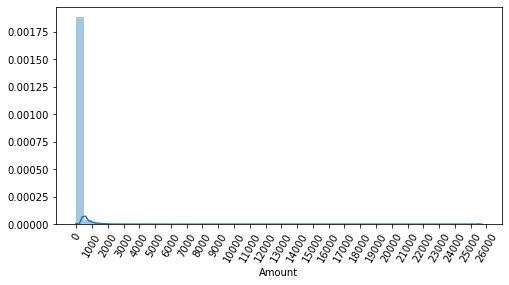

In [11]:
import seaborn as sns

# Amount 피처의 분포 확인
# Amount: 신용카드 사용 금액
# 정상/사기 트랜젝션을 결정하는 매우 중요한 속성
plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(card['Amount'])

In [12]:
# StandardScaler로 Amount 피처를 정규 분포 형태로 반환
from sklearn.preprocessing import StandardScaler

# 사이킷런의 StandardScaler를 이용하여 정규분포 형태로 Amount 피처값 변환하는 로직으로 수정. 
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    # 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame맨 앞 컬럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [14]:
# Amount를 정규분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행. 
X_train, X_test, y_train, y_test = get_train_test_dataset(card)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081, F1: 0.7143, AUC:0.9702
### LightGBM 예측 성능 ###
오차 행렬
[[85289     6]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9492, 재현율: 0.7568, F1: 0.8421, AUC:0.9773


### 데이터 분포도 변환 - 로그 변환

In [15]:
# 로그 변환은 데이터 분포도가 심히 왜곡되어 있을 경우 적용하는 중요 기법 중 하나
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    # 넘파이의 log1p( )를 이용하여 Amount를 로그 변환 
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [16]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014, F1: 0.7149, AUC:0.9727
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635, F1: 0.8496, AUC:0.9786


### 이상치 데이터 제거

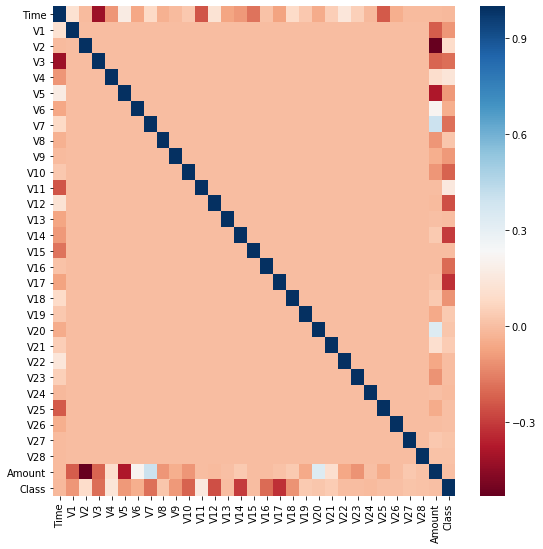

In [17]:
import seaborn as sns

# DataFrame의 corr()을 이용하여 각 피처별 상관도를 구한 뒤 시각화
plt.figure(figsize=(9, 9))
corr = card.corr()
sns.heatmap(corr, cmap='RdBu')

In [19]:
import numpy as np

# IQR을 이용해 이상치를 검출하는 함수를 생성한 뒤, 이를 이용해 검출된 이상치 삭제
def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함. 
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환. 
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

outlier_index = get_outlier(df=card, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [20]:
# get_processed_df( )를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경. 
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

In [21]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712, F1: 0.7597, AUC:0.9743
### LightGBM 예측 성능 ###
오차 행렬
[[85291     4]
 [   25   121]]
정확도: 0.9997, 정밀도: 0.9680, 재현율: 0.8288, F1: 0.8930, AUC:0.9831


### SMOTE

In [22]:
from imblearn.over_sampling import SMOTE

# SMOTE를 적용할 때는 항상 학습 데이터세트만 오버샘플링 해야함
# SMOTE 객체의 fit_sample() 메소드를 이용해 증식한 뒤 데이터를 증식 전과 비교
smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 1    199020
0    199020
Name: Class, dtype: int64


In [23]:
# 학습 데이터 세트 기반으로 로지스틱 회귀 모델 학습
lr_clf = LogisticRegression()
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247, F1: 0.1023, AUC:0.9737


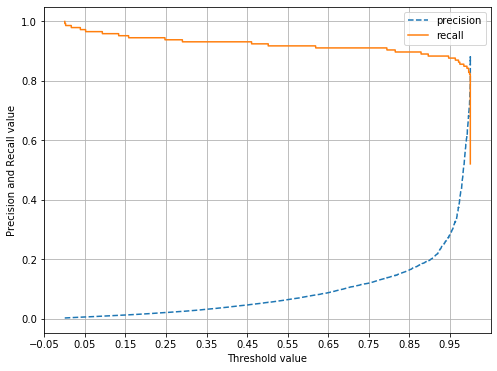

In [24]:
# 정밀도가 극도로 저하되므로 현실 업무에 사용 불가
# 로지스틱 회귀 모델이 오버 샘플링으로 인해 원본 데이터보다 너무나 많은 class=1 데이터를 학습해서 정밀도가 급격히 떨어짐
# 정밀도에 어떠한 문제가 생겼는지 시각적으로 확인
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
   
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
   
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
   
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
   
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1] )

In [25]:
# SMOTE 적용 시 재현율을 높아지나 정밀도는 낮아지는 것이 일반적
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[85286     9]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9323, 재현율: 0.8493, F1: 0.8889, AUC:0.9789


# 02 분류모델 실습
* Mobile Phone Price Classification

### Dataset 

In [32]:
import numpy as np
import pandas as pd

In [34]:
data = pd.read_csv('C:/Users/USER/BITAmin/data/mobile_train.csv')
data.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [35]:
data['price_range'].unique()

array([1, 2, 3, 0], dtype=int64)

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
battery_power    2000 non-null int64
blue             2000 non-null int64
clock_speed      2000 non-null float64
dual_sim         2000 non-null int64
fc               2000 non-null int64
four_g           2000 non-null int64
int_memory       2000 non-null int64
m_dep            2000 non-null float64
mobile_wt        2000 non-null int64
n_cores          2000 non-null int64
pc               2000 non-null int64
px_height        2000 non-null int64
px_width         2000 non-null int64
ram              2000 non-null int64
sc_h             2000 non-null int64
sc_w             2000 non-null int64
talk_time        2000 non-null int64
three_g          2000 non-null int64
touch_screen     2000 non-null int64
wifi             2000 non-null int64
price_range      2000 non-null int64
dtypes: float64(2), int64(19)
memory usage: 328.2 KB


In [38]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
battery_power,2000.0,1238.51850,439.418206,501.0,851.75,1226.0,1615.25,1998.0
blue,2000.0,0.49500,0.500100,0.0,0.00,0.0,1.00,1.0
clock_speed,2000.0,1.52225,0.816004,0.5,0.70,1.5,2.20,3.0
dual_sim,2000.0,0.50950,0.500035,0.0,0.00,1.0,1.00,1.0
fc,2000.0,4.30950,4.341444,0.0,1.00,3.0,7.00,19.0
four_g,2000.0,0.52150,0.499662,0.0,0.00,1.0,1.00,1.0
int_memory,2000.0,32.04650,18.145715,2.0,16.00,32.0,48.00,64.0
m_dep,2000.0,0.50175,0.288416,0.1,0.20,0.5,0.80,1.0
mobile_wt,2000.0,140.24900,35.399655,80.0,109.00,141.0,170.00,200.0
n_cores,2000.0,4.52050,2.287837,1.0,3.00,4.0,7.00,8.0


### EDA

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

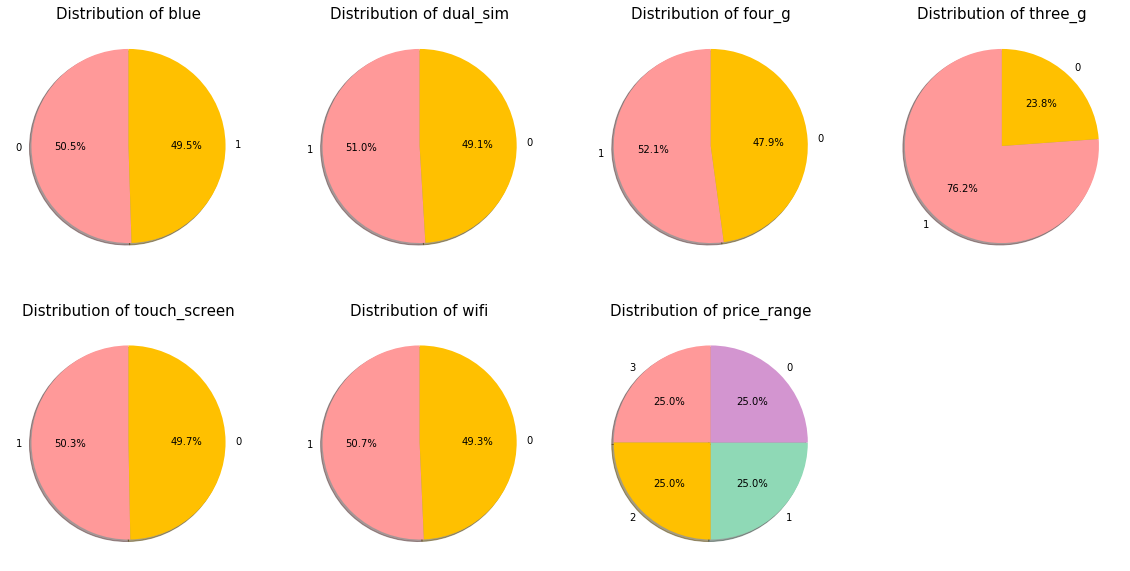

In [47]:
features = ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi', 'price_range']
plt.figure(figsize = (20,10))
count=0
for i in features:
    colors = ['#ff9999', '#ffc000', '#8fd9b6', '#d395d0']
    labels = data[i].value_counts().index
    sizes = data[i].value_counts().values
    
    plt.subplot(2,4,count+1)
    plt.pie(sizes, labels=labels, shadow=True,
           startangle=90, autopct='%1.1f%%', colors=colors)
    plt.title(f'Distribution of {features[count]}', color='black', fontsize=15)
    count += 1

In [50]:
varl = ['battery_power', 'clock_speed', 'fc', 'int_memory',
       'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'price_range']

data_continuous_var = data[varl]

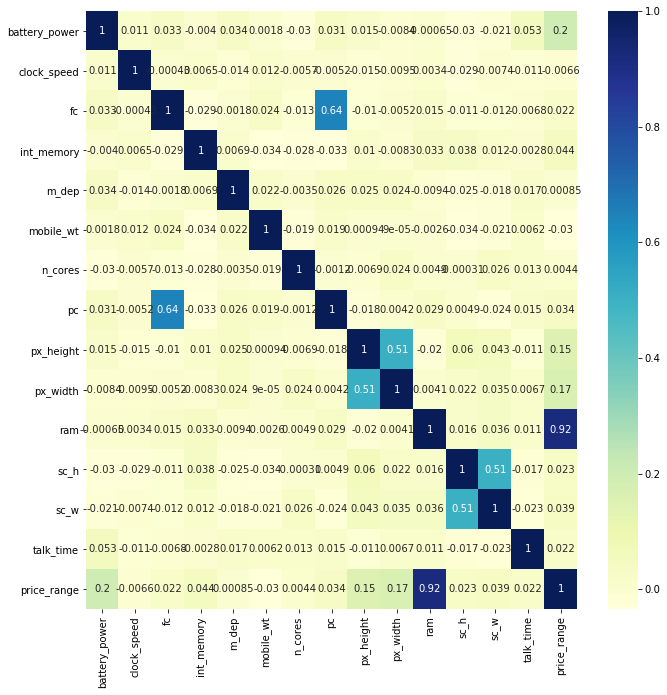

In [52]:
plt.figure(figsize=(11,11))
sns.heatmap(data_continuous_var.corr(), annot=True, cmap='YlGnBu')
plt.show()

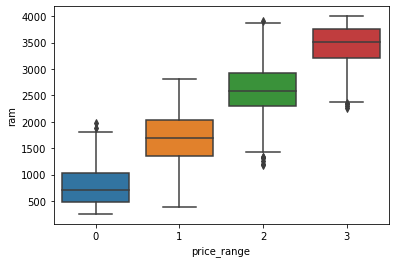

In [53]:
sns.boxplot(x='price_range', y='ram', data=data)

### Preprocessing

In [54]:
# X에는 feature들만, y에는 'price_range'만 넣어주기
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

# feature들의 값이 서로 다른 범위이므로 scaling을 통해 같은 범위로 조정
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

var = ['battery_power', 'clock_speed', 'fc', 'int_memory',
       'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time']

X_scaled = scaler.fit_transform(X[var])
X_scaled_df = pd.DataFrame(X_scaled, columns=var)

for i in var:
    X[i] = X_scaled_df[i] # 정규화된 피처들을 원본 데이터에 넣어줌

In [56]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

print(f'Total number of sample in whole dataset: {len(X)}')
print(f'Total number of sample in train dataset: {len(X_train)}')
print(f'Total number of sample in test dataset: {len(X_test)}')      

Total number of sample in whole dataset: 2000
Total number of sample in train dataset: 1600
Total number of sample in test dataset: 400


### Modeling

In [60]:
# CV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

# 알고리즘
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# 부스팅 알고리즘
from xgboost import XGBClassifier
from xgboost import plot_importance
from lightgbm import LGBMClassifier

# 성능 평가 지표
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

# GridSearchCV
from sklearn.model_selection import GridSearchCV

In [67]:
# 모델을 성능을 평가하는 함수
def model_evaluation(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average='macro')
    recall = recall_score(y_test, pred, average='macro')
    f1 = f1_score(y_test, pred, average='macro')
    
    print(confusion)
    print('accuracy:', accuracy)
    print('precision:', precision)
    print('recall:', recall)
    print('f1', f1)

In [69]:
from sklearn.model_selection import StratifiedKFold
cv_res_acc = [] # cv기반 정확도 평균: 아래 시각화에서 사용

models = {
    'RandomForestClassifier': RandomForestClassifier(),
    'SupportVectorMachine': SVC(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'XGBClassifier': XGBClassifier(),
    'LGMBClassifier': LGBMClassifier()
}

for m in models:
    clf = models[m]
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    
    print('\n**************',m,'**************')
    
    model_evaluation(y_test, pred)
    
    # cv 기반 (K-Fold) 정확도
    cv_score = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10)
    cv_res_acc.append(cv_score.mean()*100)
    print('\nCross Validation Accuracy: {:.4f}'.format(cv_score.mean()))


************** RandomForestClassifier **************
[[88  6  0  0]
 [ 9 84  9  0]
 [ 0 15 95 10]
 [ 0  0  5 79]]
accuracy: 0.865
precision: 0.8666041443277714
recall: 0.8729606204183802
f1 0.869012323079226

Cross Validation Accuracy: 0.8662

************** SupportVectorMachine **************
[[ 88   6   0   0]
 [  6  88   8   0]
 [  0  12 101   7]
 [  0   0   5  79]]
accuracy: 0.89
precision: 0.8927321138636832
recall: 0.8952645419870076
f1 0.8937459217183873

Cross Validation Accuracy: 0.8875

************** DecisionTreeClassifier **************
[[79 15  0  0]
 [ 9 85  8  0]
 [ 0 18 87 15]
 [ 0  0  5 79]]
accuracy: 0.825
precision: 0.8321229469232535
recall: 0.8348087639311044
f1 0.8298521703016086

Cross Validation Accuracy: 0.8381

************** KNeighborsClassifier **************
[[68 26  0  0]
 [27 52 20  3]
 [ 1 48 58 13]
 [ 0  3 23 58]]
accuracy: 0.59
precision: 0.6173688295133725
recall: 0.601754425174325
f1 0.606267504229647

Cross Validation Accuracy: 0.5725

************

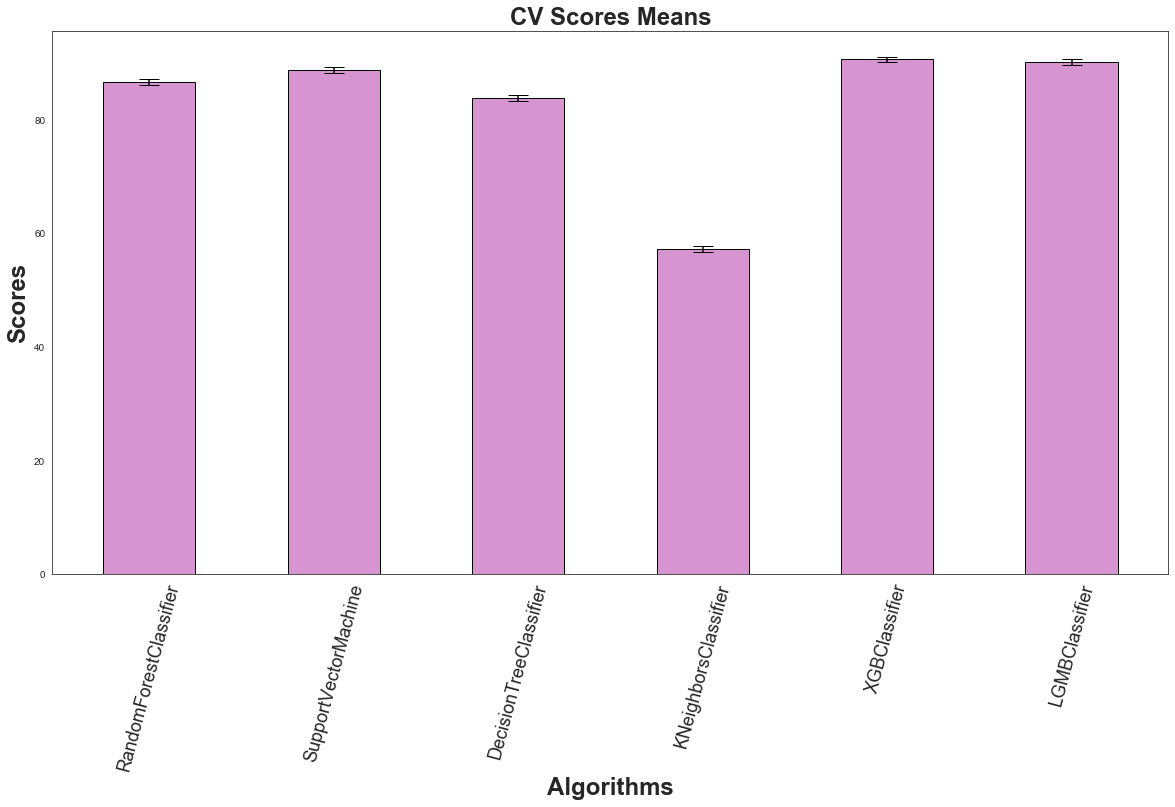

In [71]:
plt.figure(figsize=(20,10))
sns.set_style('white')

barwidth = 0.5
bars1 = cv_res_acc

r1 = np.arange(len(bars1)) # cv 기반 정확도의 평균값들 개수
r2 = [x + barwidth for x in r1] # 정확도 개수만큼

modelnames = ['RandomForestClassifier','SupportVectorMachine',
            'DecisionTreeClassifier','KNeighborsClassifier',
            'XGBClassifier','LGMBClassifier']

plt.title('CV Scores Means', fontweight='bold', size=24)
plt.bar(r2, bars1, color='#d695d0', width=barwidth, edgecolor='black', yerr=0.5, ecolor='black', capsize=10)

plt.xlabel('Algorithms', fontweight='bold', size=24)
plt.ylabel('Scores', fontweight='bold', size=24)
plt.xticks([r+barwidth for r in range(len(bars1))], modelnames, fontsize=18, rotation=75)
plt.show()

### XGBoost 추가 모델링

In [75]:
xgb_clf = XGBClassifier(n_estimators=100)

params = {'max_depth':[1,7], 'min_child_weight':[1,3], 'colsample_bytree':[0.5,0.75]}

gridcv = GridSearchCV(xgb_clf, param_grid = params, cv=3)
gridcv.fit(X_train, y_train, verbose=False)

GridSearchCV(cv=3, estimator=XGBClassifier(),
             param_grid={'colsample_bytree': [0.5, 0.75], 'max_depth': [1, 7],
                         'min_child_weight': [1, 3]})

In [76]:
print('GridSearchCV 최적 파라미터:', gridcv.best_params_)

xgb_f1_score = f1_score(y_test, gridcv.predict(X_test), average='macro')
print(f'F1_score: {xgb_f1_score:.4f}')

GridSearchCV 최적 파라미터: {'colsample_bytree': 0.75, 'max_depth': 7, 'min_child_weight': 3}
F1_score: 0.8968


In [78]:
# 위에서 나온 최적 파라미터로 설정하여 학습 후, 정확도 알아보기
xgb_clf = XGBClassifier(n_estimators=1000, random_state=156, learning_rate=0.01, max_depth=7,
                       min_child_weight=3, colsample_bytree=0.75, reg_alpha=0.03)

xgb_clf.fit(X_train, y_train, verbose=False)

xgb_f1_score = f1_score(y_test, xgb_clf.predict(X_test), average='macro')
print(f'F1_score: {xgb_f1_score:.4f}')

cv_score = cross_val_score(xgb_clf, X_train, y_train, scoring='accuracy', cv=10)
print('Cross Validation Accuracy score:', cv_score.mean())

F1_score: 0.8924
Cross Validation Accuracy score: 0.9056249999999999


### LightGBM 추가 모델링

In [83]:
lgbm_clf = LGBMClassifier(n_estimators=200)

params = {'num_leaves':[32,64], 'max_depth':[128,160],
         'min_child_samples':[60,100], 'subsample':[0.8,1]}

gridcv = GridSearchCV(lgbm_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, verbose=False)

GridSearchCV(cv=3, estimator=LGBMClassifier(n_estimators=200),
             param_grid={'max_depth': [128, 160],
                         'min_child_samples': [60, 100], 'num_leaves': [32, 64],
                         'subsample': [0.8, 1]})

In [85]:
print('GridSearchCV 최적 파라미터: ', gridcv.best_params_)
lgbm_f1_score = f1_score(y_test, gridcv.predict(X_test), average='macro')
print(f'F1_score: {lgbm_f1_score:.4f}')

GridSearchCV 최적 파라미터:  {'max_depth': 128, 'min_child_samples': 100, 'num_leaves': 32, 'subsample': 0.8}
F1_score: 0.9172


In [86]:
lgbm_clf = LGBMClassifier(n_estimators=1000, max_depth=128, 
                        min_child_samples=100, num_leaves=32, subsample=0.8)

lgbm_clf.fit(X_train, y_train, verbose=False)

lgbm_f1_score = f1_score(y_test, lgbm_clf.predict(X_test), average='macro')
print(f'F1_score: {lgbm_f1_score:.4f}')

cv_score = cross_val_score(lgbm_clf, X_train, y_train, scoring='accuracy', cv=10)
print('Cross Validation Accuracy score:', cv_score.mean())

F1_score: 0.9174
Cross Validation Accuracy score: 0.9099999999999999


# 03 스태킹 앙상블

* 스태킹 앙상블

: 여러 개의 개별 모델들이 생성한 예측 데이터를 바탕으로 최종 메타 모델이 학습/예측할 데이터 세트를 재생성하는 기법

: 개별 모델이 원본 학습 데이터에 대한 예측값을 스태킹 형태로 쌓음

: 새로 형성된 데이터를 최종 모델이 다시 학습 및 예측 수행

* 배깅 및 부스팅과의 공통점

: 개별적인 여러 알고리즘을 서로 결합해 예측 결과를 도출한다는 점

* 배깅 및 부스팅과의 차이점

: 개별 알고리즘의 예측값이 새로운 학습 데이터가 되어 최종 모델이 다시 예측을 수행한다는 점

# 04 스태킹 앙상블 실습
* Cross Validation (K-Fold) 기반 스태킹 모델 실습

In [26]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 사이킷런 내장 위스콘신 암 데이터 세트 불러오기
cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

# 학습/테스트 데이터 8:2 분할
X_train , X_test , y_train , y_test = train_test_split(X_data , y_label , test_size=0.2 , random_state=0)

In [27]:
# 개별 ML 모델을 위한 Classifier 생성
knn_clf  = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

# 최종 Stacking 모델을 위한 Classifier 생성: 로지스틱 회귀
lr_final = LogisticRegression(C=10)

In [ ]:
# 개별 모델들을 학습
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train , y_train)
dt_clf.fit(X_train , y_train)
ada_clf.fit(X_train, y_train)

# 학습된 개별 모델들이 각자 반환하는 예측 데이터 셋을 생성하고 개별 모델의 정확도 측정 
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))

In [ ]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])

# transpose를 이용해 행과 열의 위치 교환. 컬럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦
pred = np.transpose(pred)

lr_final.fit(pred, y_test)
final = lr_final.predict(pred)
print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test , final)))

In [28]:
# step1
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False, random_state=0)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))

    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  

        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
   
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    

    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [29]:
# CV스태킹 알고리즘을 각 모델에 적용하여 메타 모델이 추후에 사용할 학습/테스트 데이터 만들기
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test,  7)    
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

In [30]:
# step2: 생성된 개별 모델들의 학습/테스트 데이터 합쳐주기
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape:',X_train.shape, '원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape, '스태킹 테스트 피처 데이터 Shape:',Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


In [31]:
# 최종 메타 모델 학습/예측
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도: 0.9737
